In [126]:
!pip3 install deap

In [127]:
import pandas as pd
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import random
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier

In [128]:
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [129]:
POPULATION_SIZE = 50
P_CROSSOVER = 0.9 # probability for crossover
P_MUTATION = 0.3 #probability for mutating an individual
MAX_GENERATIONS = 80
HALL_OF_FAME_SIZE = 5
FEATURE_PENALTY_FACTOR = 0.001

random.seed(2)

Class -> (2 for benign, 4 for malignant)

In [130]:
class Breasts():

    NUM_FOLDS = 5

    def __init__(self):
        self.data = pd.read_csv('breast-cancer-wisconsin1.data')

        self.X = self.data.iloc[:, 1:10]
        self.y = self.data.iloc[:, 10]

        self.kfold = model_selection.KFold(
            n_splits=self.NUM_FOLDS, random_state=443, shuffle=True)
        self.classifier = DecisionTreeClassifier(random_state=30)

    def __len__(self):
        return self.X.shape[1]

    def get_mean_accuracy(self, zeroOneList):
        zeroIndicies = [i for i, n in enumerate(zeroOneList) if n == 0]
        currentX = self.X.drop(self.X.columns[zeroIndicies], axis=1)

        cv_results = model_selection.cross_val_score(self.classifier,
                                                     currentX,
                                                     self.y,
                                                     cv=self.kfold,
                                                     scoring='accuracy')
        return cv_results.mean()


In [131]:
breasts = Breasts()

In [132]:
toolbox = base.Toolbox()

In [133]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox.register("zeroOrOne", random.randint, 0, 1)
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, len(breasts))
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

/opt/conda/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [134]:
def breast_cancer_classification_accuracy(individual):
    numFeaturesUsed = sum(individual)
    if numFeaturesUsed == 0:
        return 0.0,
    else:
        accuracy = breasts.get_mean_accuracy(individual)
        return accuracy - FEATURE_PENALTY_FACTOR * numFeaturesUsed,

In [135]:
toolbox.register('evaluate', breast_cancer_classification_accuracy)
toolbox.register('select', tools.selTournament, tournsize=2)
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=1.0/len(breasts))

In [136]:
population = toolbox.populationCreator(n=POPULATION_SIZE)

In [137]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('max', numpy.max)
stats.register('avg', numpy.mean)

In [138]:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

In [139]:
population, logbook = eaSimpleWithElitism(population=population,
                                          toolbox=toolbox,
                                          cxpb=P_CROSSOVER,
                                          mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS,
                                          stats=stats,
                                          halloffame=hof,
                                          verbose=True)


gen	nevals	max     	avg     
0  	50    	0.956316	0.906568
1  	43    	0.956316	0.930037
2  	45    	0.956316	0.932687
3  	41    	0.956316	0.935492
4  	41    	0.956316	0.937675
5  	45    	0.956316	0.942077
6  	43    	0.956316	0.942935
7  	43    	0.956316	0.942266
8  	42    	0.956316	0.944161
9  	41    	0.956316	0.945538
10 	41    	0.956316	0.947272
11 	40    	0.956316	0.94799 
12 	40    	0.956316	0.949552
13 	45    	0.956316	0.94922 
14 	44    	0.956316	0.948755
15 	40    	0.956316	0.949777
16 	34    	0.956316	0.947919
17 	44    	0.956316	0.949061
18 	32    	0.956316	0.949722
19 	43    	0.956316	0.946887
20 	39    	0.956316	0.952538
21 	38    	0.956316	0.950559
22 	40    	0.956316	0.95122 
23 	43    	0.956316	0.950039
24 	40    	0.956316	0.950033
25 	38    	0.956316	0.948408
26 	40    	0.956316	0.948035
27 	43    	0.956316	0.95043 
28 	42    	0.956316	0.949853
29 	43    	0.956316	0.950307
30 	38    	0.956316	0.950891
31 	40    	0.956316	0.948402
32 	40    	0.956316	0.949276
33 	45    	0.9

In [140]:
print('- Лучшие решения:')
for i in range(HALL_OF_FAME_SIZE):
    print(i, ': ', hof.items[i], ', приспособленность = ', hof.items[i].fitness.values[0],
          ', верность = ', breasts.get_mean_accuracy(hof.items[i]),
          ', признаков = ', sum(hof.items[i]))

- Лучшие решения:
0 :  [1, 0, 0, 1, 0, 1, 1, 1, 0] , приспособленность =  0.9563155190133608 , верность =  0.9613155190133608 , признаков =  5
1 :  [1, 0, 0, 0, 1, 1, 0, 1, 1] , приспособленность =  0.9520195272353544 , верность =  0.9570195272353544 , признаков =  5
2 :  [1, 0, 1, 0, 0, 0, 0, 1, 0] , приспособленность =  0.9511623843782118 , верность =  0.9541623843782118 , признаков =  3
3 :  [1, 0, 0, 0, 1, 1, 0, 1, 0] , приспособленность =  0.9501418293936278 , верность =  0.9541418293936278 , признаков =  4
4 :  [1, 0, 0, 1, 0, 1, 0, 1, 0] , приспособленность =  0.9486927029804728 , верность =  0.9526927029804728 , признаков =  4


In [141]:
maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

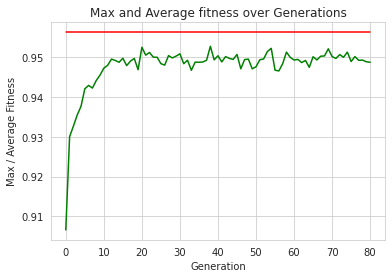

In [142]:
sns.set_style('whitegrid')
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt. xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average fitness over Generations')
plt.show()

In [143]:
allOnes = [1] * len(breasts)
print('-- Выделены все признаки: ', allOnes, ', accuracy = ', breasts.get_mean_accuracy(allOnes))

-- Выделены все признаки:  [1, 1, 1, 1, 1, 1, 1, 1, 1] , accuracy =  0.9384069886947584


In [152]:
diff = breasts.get_mean_accuracy(hof.items[0]) - breasts.get_mean_accuracy(allOnes)
print('Верность повысилась на {:.4f}'.format(diff))

Верность повысилась на 0.0229
